In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics
plt.figure(dpi=1200)
from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy.stats import linregress
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test

## Basic algorythm to calculate the normalized FRET efficiencys, based on the average FRET efficiency values of the measurements with wild type podocin on that day

In [3]:
figdata = pd.read_excel(r'Source_Data_work_file.xlsx', sheet_name='FRET EC-signed  - podocin types')
refdata = []
normmean = []
for iterat in list(dict.fromkeys(figdata['Repeat'])):                                            # Divising the data by the day the measurement was taken
    ref = (figdata['Mutation'] == 'podocin WT') & (figdata['Repeat'] == iterat)                  # The reference values are the measurements taken with the wild type podocin on that specific day
    data = figdata[ref==True].index.tolist()                                                     # Gaining the index of the sought measurement
    refer = []
    for ind in data:
        reference = figdata.at[ind, figdata.columns[1]]                                          # Getting the FRET values with the help of the index
        refer.append(reference)     
    refdata.append([iterat, statistics.mean(refer)])                                             # Calculating the mean of the podocin values
for iterat, mean_value in refdata:                                                               # Calculating the normalized values
    for position in figdata.index.to_list():
        iteration = figdata.loc[position, figdata.columns[2]]
        if iteration == iterat:
            normmean.append(figdata.loc[position,figdata.columns[1]]/mean_value)
figdata['Normmean_check'] = normmean                                                             # Appending the normalized values to the DataFrame
#display(figdata)

## Podocin-nephrin correlation statistic and data visualization

In [5]:
podocin_nephrin_corr = pd.read_excel(r'Source_Data_work_file.xlsx', sheet_name='Corr. between p-p and n-n FRET')
nephrin = podocin_nephrin_corr["Nephrin_FRET_Av"].to_numpy()
podocin = podocin_nephrin_corr["NORM_FRET"].to_numpy()
#display(podocin_nephrin_corr)

Exponential Fit: y = (a*(x**b))
	a = popt[0] = 0.013152663532139529
	b = popt[1] = -1.3492301935718753
pcov= [[6.25348951e-05 3.26806858e-03]
 [3.26806858e-03 1.75690920e-01]]


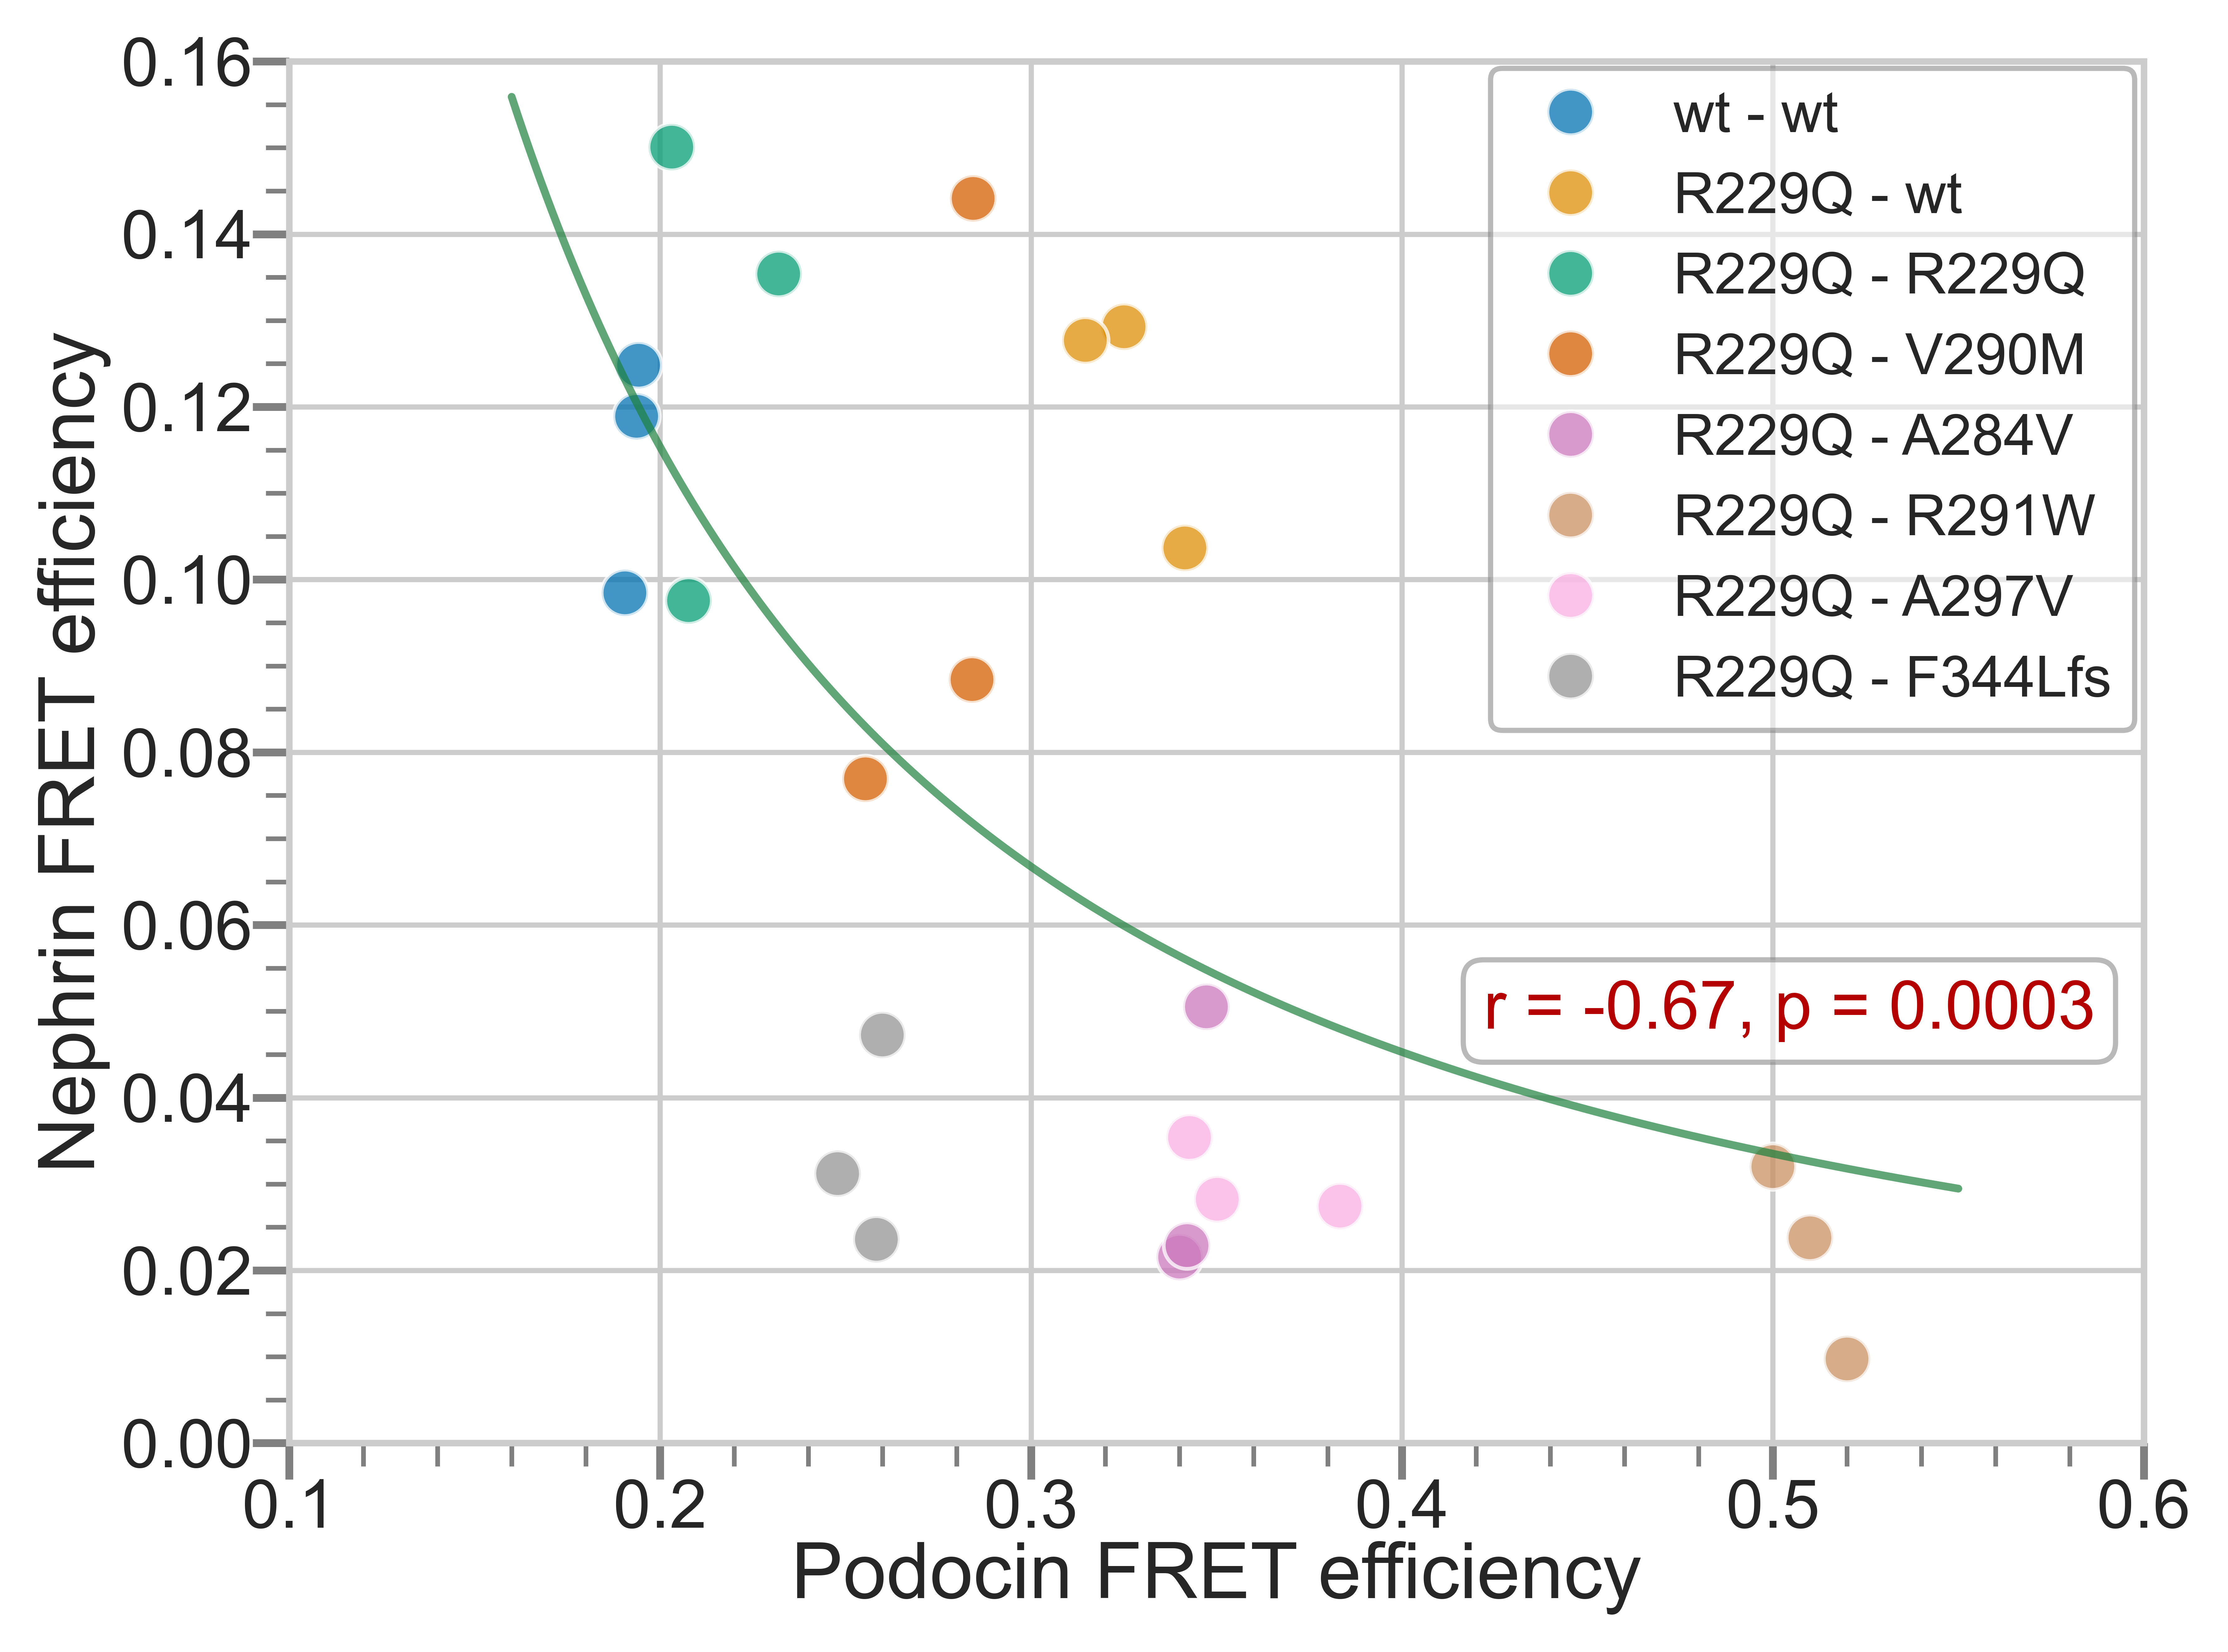

In [7]:
sns.set_theme(style="whitegrid", rc={"xtick.bottom" : True, "ytick.left" : True})
#ax.clear()
myplot = sns.scatterplot(data=podocin_nephrin_corr, # Data source
                         x='NORM_FRET', # Horizontal axis
                         y='Nephrin_FRET_Av', # Vertical axis
                         hue = "Association",
                         palette = sns.color_palette('colorblind', 8),
                         alpha = 0.75,
                         s= 80) # size and dimension

# Set x-axis label
plt.xlabel('Podocin FRET efficiency', labelpad= 0.0, fontsize=15)
# Set y-axis label
plt.ylabel('Nephrin FRET efficiency', labelpad= 2.0, fontsize=15)

myplot.minorticks_on()

def myExpFunc(x, a, b):
    return a * np.power(x, b)

# Using the myExpFunc, I fit the podocin-nephrin correlation with podocin as the independent variable
newX = np.linspace(0.16, 0.55, num=250)
popt, pcov = curve_fit(myExpFunc, podocin, nephrin, absolute_sigma= False, full_output=False)
plt.plot(newX, myExpFunc(newX, *popt), color="#1d813e", alpha=0.7,)
print("Exponential Fit: y = (a*(x**b))")
print("\ta = popt[0] = {0}\n\tb = popt[1] = {1}".format(*popt))
print("pcov=", pcov)

# Modifying the legend
myplot.legend(bbox_to_anchor=(0.995, 0.995), loc='upper right', borderaxespad=0, framealpha=0.55, edgecolor="grey")

# Set the limits for the grid
myplot.set(xlim=(0.1,0.6), ylim=(0,0.16))
myplot.tick_params(axis="both", labelsize=13, pad=-3)
myplot.tick_params(axis="both", which="major", direction='out', length=7.0, width=1.5,labelsize=13, pad=0, color="grey",)
myplot.tick_params(axis="x", which="minor", direction='out', length=4.5, width=0.9, pad=0.8, color="grey", labelsize=10, labelbottom= True)
myplot.tick_params(axis="y", which="minor", direction='out', length=4.5, width=0.9, pad=0.8, color="grey", labelsize=10, labelleft= True)

# Statistics
r, p = stats.pearsonr(np.log10(podocin), np.log10(nephrin))
myplot.text(0.422, 0.048, 'r = {:.2f}, p = {:.2g}'.format(r, p), color="#B50000", fontsize=13, backgroundcolor='white', bbox = dict(facecolor='white', edgecolor='grey', alpha=0.55, boxstyle='round'))
myplot.get_figure()
#plt.savefig('Podocin_nephrin_correlation.tif', bbox_inches='tight', dpi=2000)

# Statistics of renal survival of patients with different NPHS2 variants

In [9]:
Kaplan_Meier_data = pd.read_excel(r'Source_Data_work_file.xlsx', sheet_name='Patients in literature')
names = Kaplan_Meier_data['Groups'].unique()                      # Previously established groups based on the podocin variants of the patients
age = Kaplan_Meier_data['ESRD_year']                              # Age at ESRD or last follow-up
esrd = Kaplan_Meier_data['ESRD']                                  # Whether the patient has ESRD (1) or not (0)
#display(Kaplan_Meier_data)

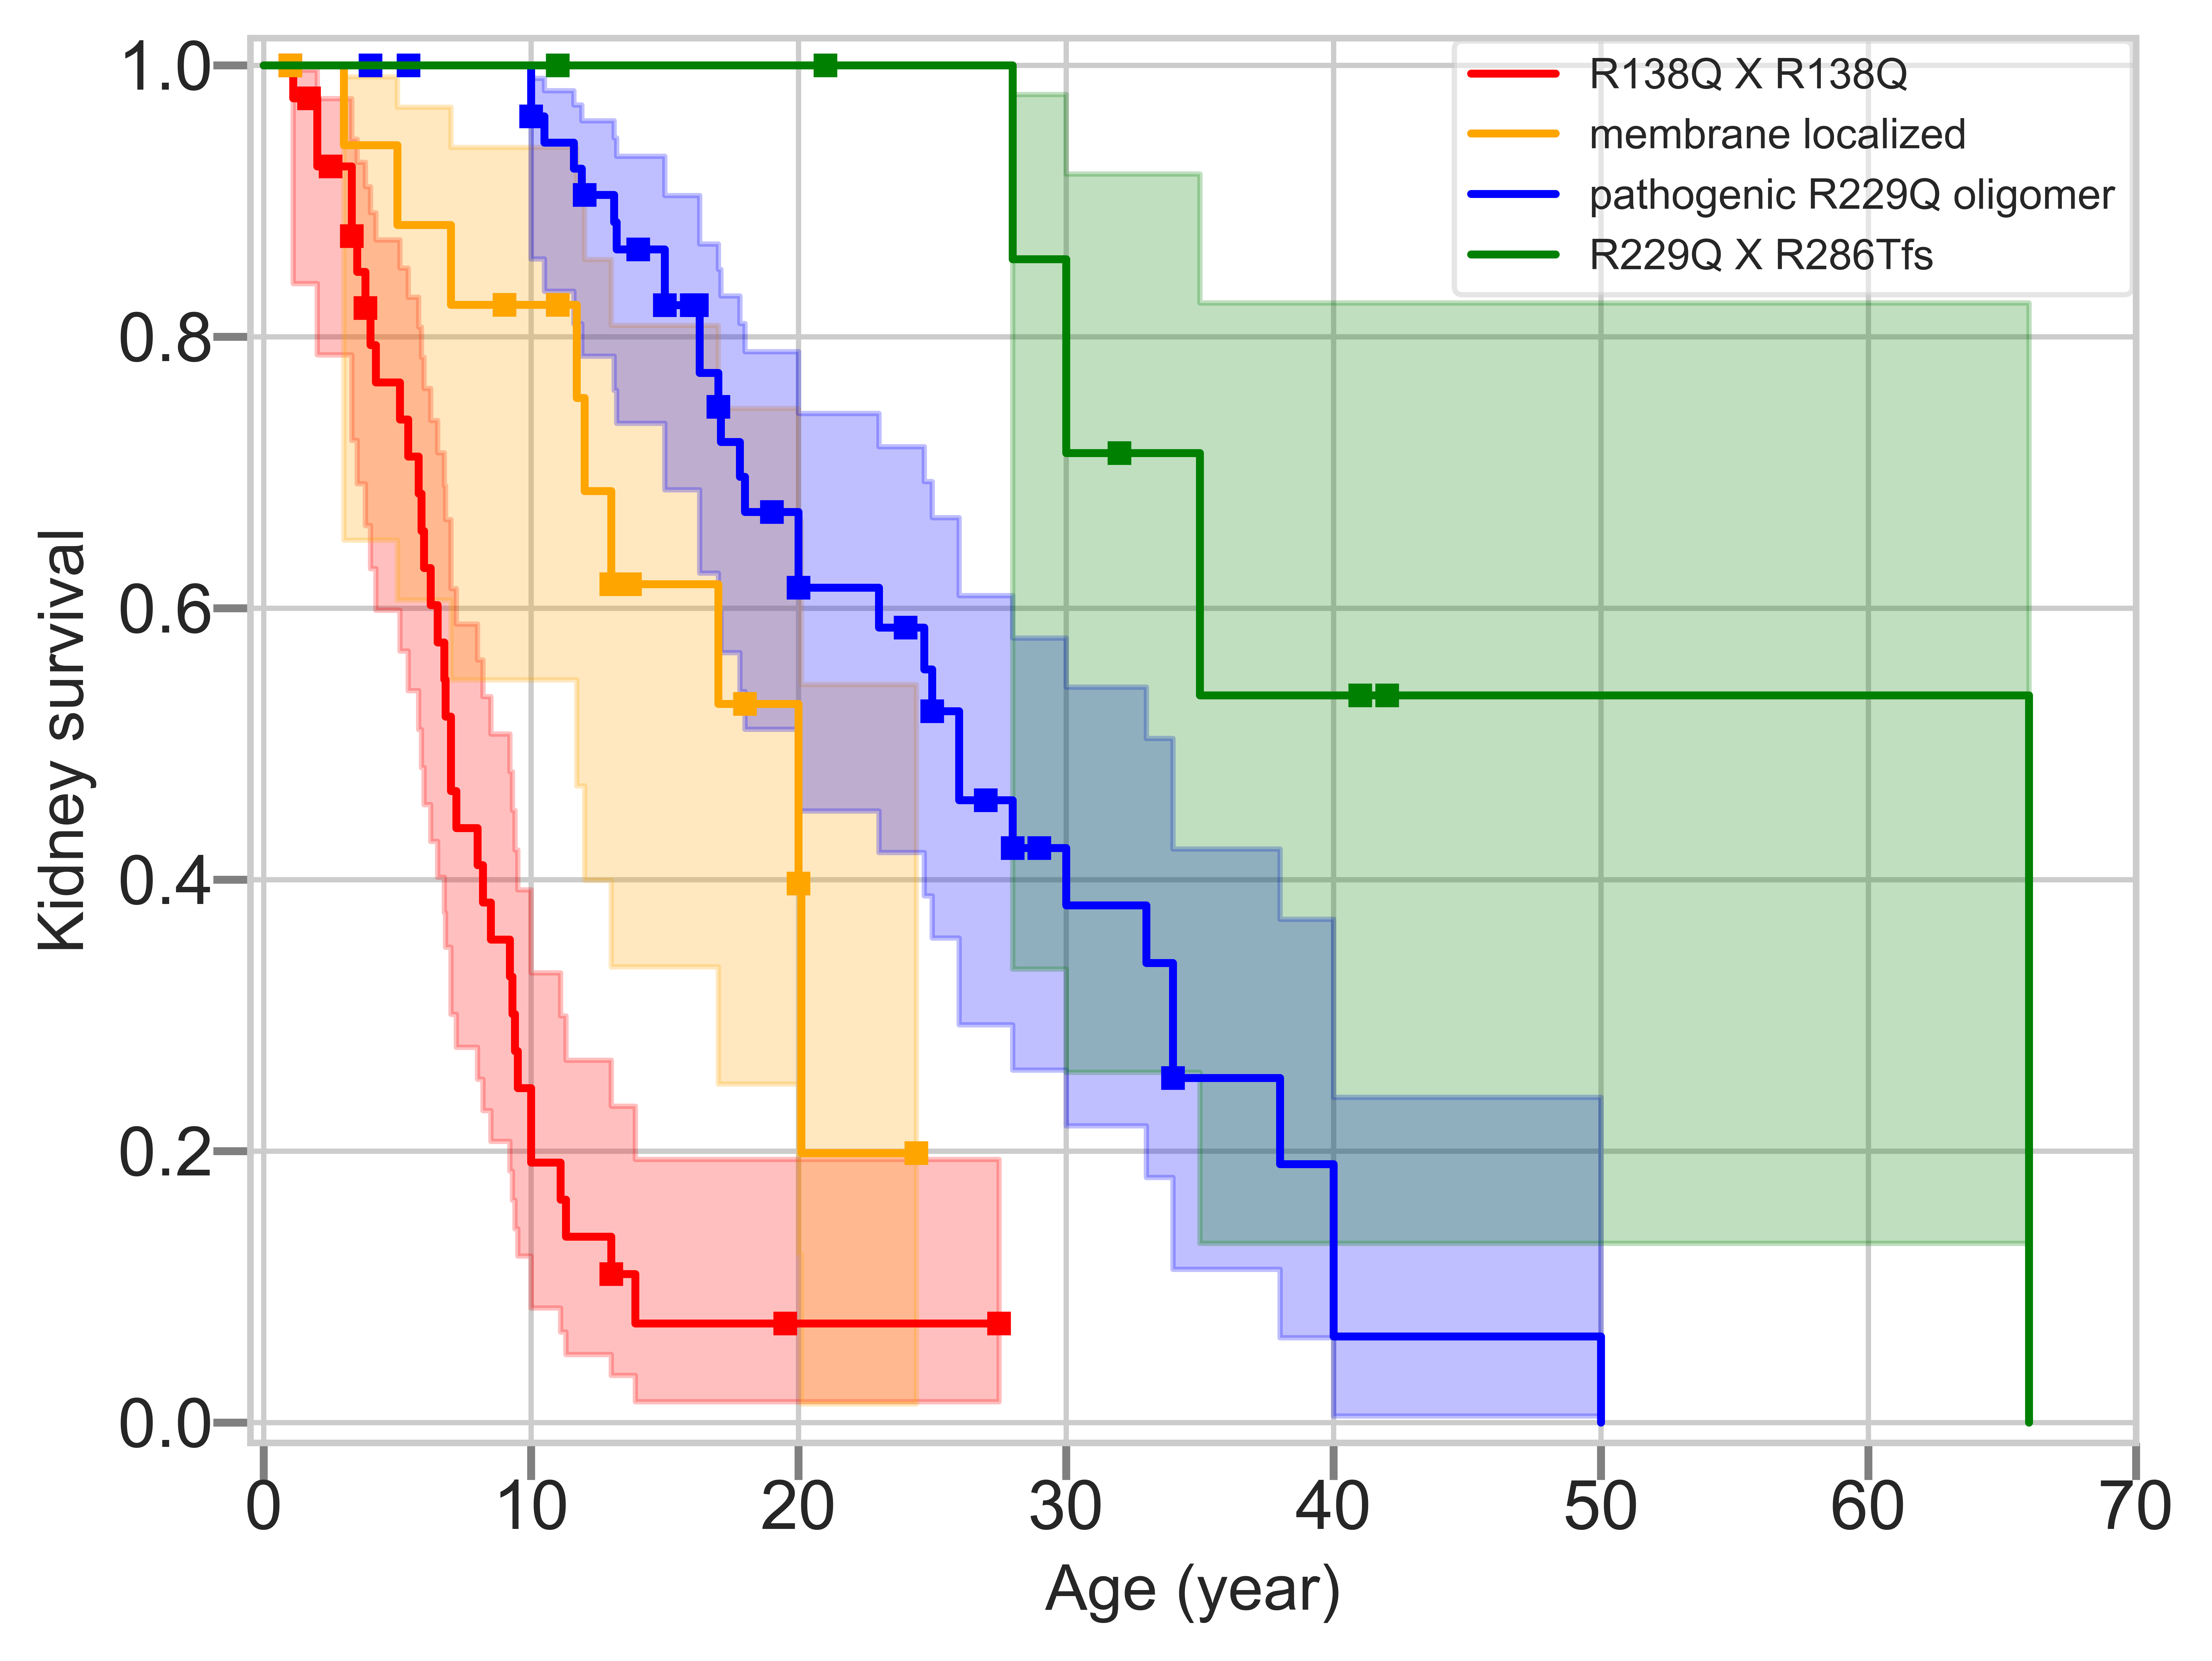

In [15]:
names = Kaplan_Meier_data['Groups'].unique()
age = Kaplan_Meier_data['ESRD_year']
esrd = Kaplan_Meier_data['ESRD']

#ax.clear()
# Kaplan-Meier curve of patients with homozygous R138Q variant
kmf_R138Q = KaplanMeierFitter()
R138Q = Kaplan_Meier_data['Groups'] == names[1]
kmf_R138Q.fit(age[R138Q], esrd[R138Q], label = names[1])
ax = kmf_R138Q.plot(show_censors=True, censor_styles={'ms': 3.5, 'marker': 's','label':'_out_'}, ci_show=True, color="red")

# Kaplan-Meier curve of patients with pathogenic membrane localized podocin associations and variants
kmf_membrane = KaplanMeierFitter()
membrane = Kaplan_Meier_data['Groups'] == names[0]
kmf_membrane.fit(age[membrane], esrd[membrane], label = 'membrane localized')
ax = kmf_membrane.plot(show_censors=True, censor_styles={'ms': 3.5, 'marker': 's','label':'_out_'}, ax=ax, ci_show=True, color="orange")

# Kaplan-Meier curve of patients with pathogenic R229Q associations
kmf_R229Q = KaplanMeierFitter()
R229Q = Kaplan_Meier_data['Groups'] == names[2]
kmf_R229Q.fit(age[R229Q], esrd[R229Q], label = 'pathogenic R229Q oligomer')
ax = kmf_R229Q.plot(show_censors=True, censor_styles={'ms': 3.5, 'marker': 's','label':'_out_'}, ax=ax, ci_show=True, color="blue")

# Kaplan-Meier curve of patients with R229Q x R286Tfs association
kmf_R286Tfs = KaplanMeierFitter()
R286Tfs = Kaplan_Meier_data['Groups'] == names[3]
kmf_R286Tfs.fit(age[R286Tfs], esrd[R286Tfs], label = names[3])
ax = kmf_R286Tfs.plot(show_censors=True, censor_styles={'ms': 3.5, 'marker': 's','label':'_out_'}, ax=ax, ci_show=True, color="green")

ax.set_xlim([-0.5, 70])
ax.set_ylim([-0.015, 1.02])
ax.set_ylabel("Kidney survival", size=12)
ax.set_xlabel("Age (year)", size=12)
ax.legend(bbox_to_anchor=(0.998, 0.998), loc='upper right', borderaxespad=0, framealpha=0.5, fontsize=8)
#plt.legend(loc='upper right')

ax.get_figure()
#ax.get_figure().savefig('kaplan-meier_curve_with_confidence_with_censored_data.png', format='png', bbox_inches='tight', dpi=2000, )

In [64]:
# Difference between the renal survival of patients with homozygous R138Q and pathogenic R229Q associations
results = logrank_test(age[R229Q], age[R138Q], event_observed_A=esrd[R229Q], event_observed_B=esrd[R138Q])
results.print_summary()
print(results.p_value)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          70.92 <0.005     54.58

3.714349047666716e-17


In [66]:
# Difference between the renal survival of patients with membrane localized pathogenic associations and pathogenic R229Q associations
results = logrank_test(age[R229Q], age[membrane], event_observed_A=esrd[R229Q], event_observed_B=esrd[membrane])
results.print_summary()
print(results.p_value)        

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.07 0.02      5.36

0.024290916999674984


In [68]:
# Difference between the renal survival of patients with R229Q X R286Tfs association and pathogenic R229Q associations
results = logrank_test(age[R229Q], age[R286Tfs], event_observed_A=esrd[R229Q], event_observed_B=esrd[R286Tfs])
results.print_summary()
print(results.p_value)       

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.65 0.01      6.66

0.009914780324527481
